In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, accuracy_score,
                             average_precision_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


# Fraud Detection - End-to-End Machine Learning Pipeline

## Objective
Design and implement an end-to-end machine learning pipeline to predict the probability of an online transaction being fraudulent.

## Workflow Overview:
1. **Data Loading & Exploration** - Load and understand the dataset
2. **Data Preprocessing** - Handle missing values, encode categorical variables
3. **Feature Engineering & Selection** - Create and select relevant features
4. **Handle Class Imbalance** - Apply techniques like SMOTE
5. **Model Training** - Train ML models (Logistic Regression, Random Forest, Gradient Boosting)
6. **Hyperparameter Tuning** - Basic tuning for model optimization
7. **Model Evaluation** - Evaluate using appropriate metrics (ROC-AUC, F1-Score, etc.)
8. **Prediction** - Generate predictions on test data

## 1. Data Loading

In [2]:
# Load the data
train_df = pd.read_csv("train_transaction.csv")
test_df = pd.read_csv("test_transaction.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nTraining columns: {train_df.columns.tolist()[:20]}...")  # Show first 20 columns

Training data shape: (590540, 394)
Test data shape: (506691, 393)

Training columns: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3']...


## 2. Exploratory Data Analysis (EDA)

DATASET OVERVIEW

Training set: 590,540 rows, 394 columns
Test set: 506,691 rows, 393 columns

TARGET VARIABLE DISTRIBUTION (isFraud)

Not Fraud (0): 569,877 (96.50%)
Fraud (1): 20,663 (3.50%)

Imbalance Ratio: 27.58:1


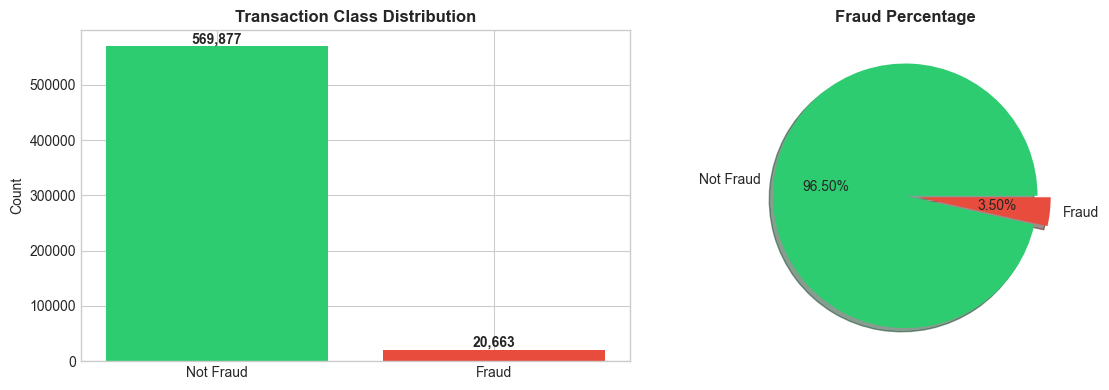

In [3]:
# Basic info about the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTraining set: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")
print(f"Test set: {test_df.shape[0]:,} rows, {test_df.shape[1]} columns")

# Check target variable distribution (Class Imbalance)
print("\n" + "=" * 60)
print("TARGET VARIABLE DISTRIBUTION (isFraud)")
print("=" * 60)
fraud_counts = train_df['isFraud'].value_counts()
fraud_pct = train_df['isFraud'].value_counts(normalize=True) * 100
print(f"\nNot Fraud (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraud (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.2f}:1")

# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Not Fraud', 'Fraud'], fraud_counts.values, color=colors)
axes[0].set_title('Transaction Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(fraud_counts.values, labels=['Not Fraud', 'Fraud'], autopct='%1.2f%%', 
            colors=colors, explode=[0, 0.1], shadow=True)
axes[1].set_title('Fraud Percentage', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

MISSING VALUES ANALYSIS

Top 20 columns with highest missing values:
       Missing Count  Missing Percentage
dist2         552913           93.628374
D7            551623           93.409930
D13           528588           89.509263
D14           528353           89.469469
D12           525823           89.041047
D6            517353           87.606767
D9            515614           87.312290
D8            515614           87.312290
V153          508595           86.123717
V149          508595           86.123717
V141          508595           86.123717
V146          508595           86.123717
V154          508595           86.123717
V162          508595           86.123717
V142          508595           86.123717
V158          508595           86.123717
V161          508595           86.123717
V157          508595           86.123717
V138          508595           86.123717
V139          508595           86.123717

Columns with >50% missing values: 174


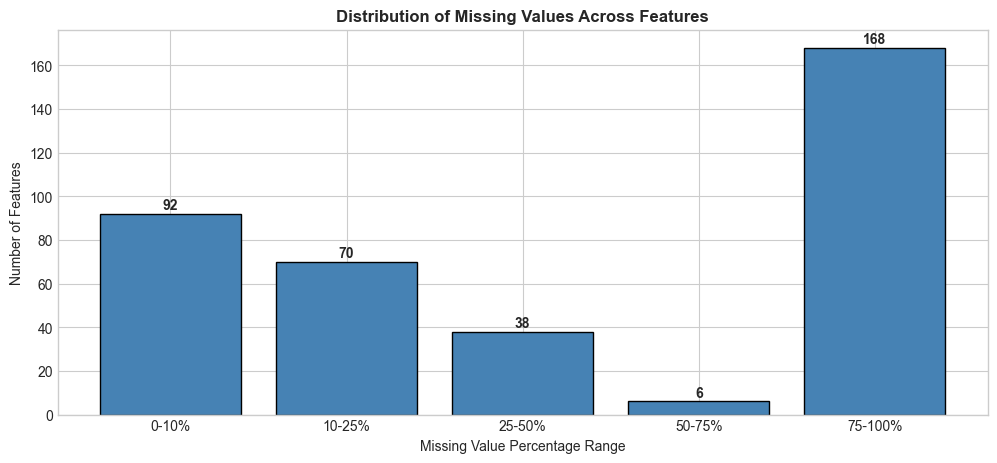

In [4]:
# Analyze missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_counts = train_df.isnull().sum()
missing_pct = (train_df.isnull().sum() / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_pct
}).sort_values('Missing Percentage', ascending=False)

# Show top 20 columns with most missing values
print("\nTop 20 columns with highest missing values:")
print(missing_df[missing_df['Missing Count'] > 0].head(20))

# Visualize missing values for columns with >50% missing
high_missing = missing_df[missing_df['Missing Percentage'] > 50]
print(f"\nColumns with >50% missing values: {len(high_missing)}")

# Plot missing values distribution
plt.figure(figsize=(12, 5))
missing_ranges = pd.cut(missing_pct, bins=[0, 10, 25, 50, 75, 100], 
                        labels=['0-10%', '10-25%', '25-50%', '50-75%', '75-100%'])
missing_ranges_count = missing_ranges.value_counts().sort_index()
plt.bar(missing_ranges_count.index, missing_ranges_count.values, color='steelblue', edgecolor='black')
plt.title('Distribution of Missing Values Across Features', fontsize=12, fontweight='bold')
plt.xlabel('Missing Value Percentage Range')
plt.ylabel('Number of Features')
for i, v in enumerate(missing_ranges_count.values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')
plt.show()

DATA TYPES ANALYSIS

Data types distribution:
float64    376
object      14
int64        4
Name: count, dtype: int64

Categorical columns (14): ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

Numerical columns: 380


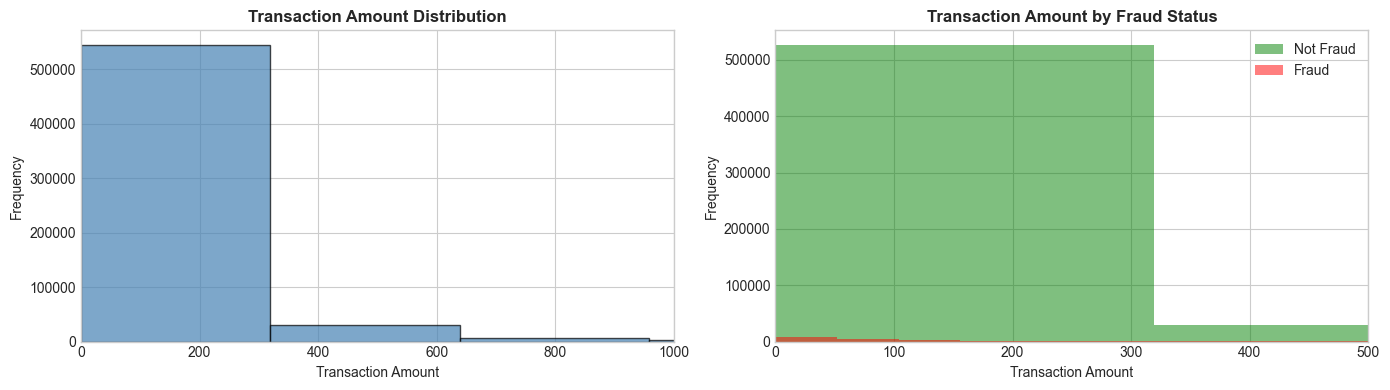


Transaction Amount Statistics:
            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  


In [5]:
# Analyze data types
print("=" * 60)
print("DATA TYPES ANALYSIS")
print("=" * 60)

dtype_counts = train_df.dtypes.value_counts()
print("\nData types distribution:")
print(dtype_counts)

# Identify categorical and numerical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns: {len(numerical_cols)}")

# TransactionAmt distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Transaction Amount Distribution
axes[0].hist(train_df['TransactionAmt'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Transaction Amount Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 1000)  # Focus on amounts < $1000

# Transaction Amount by Fraud status
fraud_amt = train_df[train_df['isFraud'] == 1]['TransactionAmt']
non_fraud_amt = train_df[train_df['isFraud'] == 0]['TransactionAmt']
axes[1].hist(non_fraud_amt, bins=100, alpha=0.5, label='Not Fraud', color='green')
axes[1].hist(fraud_amt, bins=100, alpha=0.5, label='Fraud', color='red')
axes[1].set_title('Transaction Amount by Fraud Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Transaction Amount')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 500)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nTransaction Amount Statistics:")
print(train_df.groupby('isFraud')['TransactionAmt'].describe())

## 3. Data Preprocessing

### 3.1 Handle Missing Values
- Drop columns with >80% missing values
- Impute numerical columns with median
- Impute categorical columns with mode

In [6]:
# Store TransactionID for later use
train_transaction_ids = train_df['TransactionID'].copy()
test_transaction_ids = test_df['TransactionID'].copy()

# Separate target variable
y = train_df['isFraud'].copy()
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)
X_test = test_df.drop(['TransactionID'], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")

Features shape: (590540, 392)
Target shape: (590540,)
Test features shape: (506691, 392)


In [7]:
# Drop columns with >80% missing values
threshold = 0.8
missing_pct = X.isnull().sum() / len(X)
cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()

print(f"Dropping {len(cols_to_drop)} columns with >{threshold*100}% missing values")
print(f"Columns to drop: {cols_to_drop[:10]}..." if len(cols_to_drop) > 10 else f"Columns to drop: {cols_to_drop}")

X = X.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

print(f"\nShape after dropping high-missing columns: {X.shape}")

Dropping 55 columns with >80.0% missing values
Columns to drop: ['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139']...

Shape after dropping high-missing columns: (590540, 337)


In [8]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns: {len(numerical_cols)}")

Categorical columns (14): ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
Numerical columns: 323


In [9]:
# Handle missing values
print("Handling missing values...")

# For numerical columns: impute with median
num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])

# For categorical columns: impute with mode (most frequent)
for col in categorical_cols:
    mode_val = X[col].mode()[0] if not X[col].mode().empty else 'Unknown'
    X[col] = X[col].fillna(mode_val)
    X_test[col] = X_test[col].fillna(mode_val)

print(f"Missing values in X after imputation: {X.isnull().sum().sum()}")
print(f"Missing values in X_test after imputation: {X_test.isnull().sum().sum()}")

Handling missing values...
Missing values in X after imputation: 0
Missing values in X_test after imputation: 0


### 3.2 Encode Categorical Variables
Using Label Encoding for categorical columns

In [10]:
# Label encode categorical columns
print("Encoding categorical variables...")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Combine train and test to ensure all categories are encoded
    combined = pd.concat([X[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} unique values")

print(f"\nData types after encoding:")
print(X.dtypes.value_counts())

Encoding categorical variables...
  ProductCD: 5 unique values
  card4: 4 unique values
  card6: 4 unique values
  P_emaildomain: 60 unique values
  R_emaildomain: 60 unique values
  M1: 2 unique values
  M2: 2 unique values
  M3: 2 unique values
  M4: 3 unique values
  M5: 2 unique values
  M6: 2 unique values
  M7: 2 unique values
  M8: 2 unique values
  M9: 2 unique values

Data types after encoding:
float64    323
int64       14
Name: count, dtype: int64


## 4. Feature Engineering & Selection

In [11]:
# Feature Engineering: Create new features from TransactionDT
print("Creating time-based features...")

# TransactionDT represents seconds from a reference datetime
# Extract time-based features
X['Transaction_Hour'] = (X['TransactionDT'] // 3600) % 24
X['Transaction_DayOfWeek'] = (X['TransactionDT'] // 86400) % 7
X['Transaction_Day'] = (X['TransactionDT'] // 86400) % 30

X_test['Transaction_Hour'] = (X_test['TransactionDT'] // 3600) % 24
X_test['Transaction_DayOfWeek'] = (X_test['TransactionDT'] // 86400) % 7
X_test['Transaction_Day'] = (X_test['TransactionDT'] // 86400) % 30

# Log transform for TransactionAmt (handle skewness)
X['TransactionAmt_Log'] = np.log1p(X['TransactionAmt'])
X_test['TransactionAmt_Log'] = np.log1p(X_test['TransactionAmt'])

# Transaction amount statistics
X['TransactionAmt_decimal'] = ((X['TransactionAmt'] - X['TransactionAmt'].astype(int)) * 1000).astype(int)
X_test['TransactionAmt_decimal'] = ((X_test['TransactionAmt'] - X_test['TransactionAmt'].astype(int)) * 1000).astype(int)

print(f"New features created. Shape: {X.shape}")

Creating time-based features...
New features created. Shape: (590540, 342)


In [12]:
# Feature Selection: Remove low variance features and highly correlated features
from sklearn.feature_selection import VarianceThreshold

print("Performing feature selection...")

# Remove constant/quasi-constant features
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()].tolist()

print(f"Features before selection: {X.shape[1]}")
print(f"Features after variance threshold: {len(selected_features)}")

X = X[selected_features]
X_test = X_test[selected_features]

print(f"\nFinal feature set shape: {X.shape}")

Performing feature selection...
Features before selection: 342
Features after variance threshold: 317

Final feature set shape: (590540, 317)


## 5. Train-Validation Split & Handle Class Imbalance

In [13]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in validation set:")
print(y_val.value_counts())

Training set: (472432, 317)
Validation set: (118108, 317)

Class distribution in training set:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Class distribution in validation set:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [14]:
# Handle Class Imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
print("Applying SMOTE to handle class imbalance...")
print(f"Before SMOTE - Class distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")

# Use SMOTE with undersampling for efficiency
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Increase minority to 50% of majority
undersampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Then undersample majority

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print(f"After SMOTE + Undersampling - Class distribution: {dict(zip(*np.unique(y_train_resampled, return_counts=True)))}")
print(f"Resampled training set shape: {X_train_resampled.shape}")

Applying SMOTE to handle class imbalance...
Before SMOTE - Class distribution: {np.int64(0): np.int64(455902), np.int64(1): np.int64(16530)}
After SMOTE + Undersampling - Class distribution: {np.int64(0): np.int64(284938), np.int64(1): np.int64(227951)}
Resampled training set shape: (512889, 317)


In [15]:
# Scale features for models that require it
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete!")

Scaling features...
Feature scaling complete!


## 6. Model Training

We will train multiple models and compare their performance:
1. Logistic Regression (Baseline)
2. Random Forest Classifier
3. Gradient Boosting Classifier

In [16]:
# Function to evaluate model and display results
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Train and evaluate a model with comprehensive metrics"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print('='*60)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_pred)
    avg_precision = average_precision_score(y_val, y_pred_proba)
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC-AUC Score: {roc_auc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Average Precision: {avg_precision:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))
    
    return model, y_pred, y_pred_proba, {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1_score': f1,
        'avg_precision': avg_precision
    }

In [17]:
# Model 1: Logistic Regression (Baseline)
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model, lr_pred, lr_pred_proba, lr_metrics = evaluate_model(
    lr_model, X_train_scaled, y_train_resampled, X_val_scaled, y_val, "Logistic Regression"
)


Training Logistic Regression...

Logistic Regression Results:
  Accuracy: 0.8827
  ROC-AUC Score: 0.8205
  F1 Score: 0.2575
  Average Precision: 0.3791

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.98      0.89      0.94    113975
       Fraud       0.17      0.58      0.26      4133

    accuracy                           0.88    118108
   macro avg       0.57      0.74      0.60    118108
weighted avg       0.95      0.88      0.91    118108



In [ ]:

# Model 2: Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model, rf_pred, rf_pred_proba, rf_metrics = evaluate_model(
    rf_model, X_train_resampled, y_train_resampled, X_val, y_val, "Random Forest"
)


Training Random Forest...

Random Forest Results:
  Accuracy: 0.9743
  ROC-AUC Score: 0.8907
  F1 Score: 0.5469
  Average Precision: 0.5559

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.98      0.99      0.99    113975
       Fraud       0.71      0.44      0.55      4133

    accuracy                           0.97    118108
   macro avg       0.85      0.72      0.77    118108
weighted avg       0.97      0.97      0.97    118108



In [19]:
# Model 3: Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
gb_model, gb_pred, gb_pred_proba, gb_metrics = evaluate_model(
    gb_model, X_train_resampled, y_train_resampled, X_val, y_val, "Gradient Boosting"
)


Training Gradient Boosting...

Gradient Boosting Results:
  Accuracy: 0.9728
  ROC-AUC Score: 0.8885
  F1 Score: 0.5358
  Average Precision: 0.5356

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.98      0.99      0.99    113975
       Fraud       0.67      0.45      0.54      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.72      0.76    118108
weighted avg       0.97      0.97      0.97    118108



## 7. Hyperparameter Tuning (Basic Level)

Using GridSearchCV for basic hyperparameter optimization on the best performing model.

In [20]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest (typically performs well for fraud detection)
print("Performing hyperparameter tuning on Random Forest...")

# Define parameter grid (basic level tuning)
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]
}

# Use a smaller sample for faster tuning
sample_size = min(50000, len(X_train_resampled))
indices = np.random.choice(len(X_train_resampled), sample_size, replace=False)
X_sample = X_train_resampled.iloc[indices] if hasattr(X_train_resampled, 'iloc') else X_train_resampled[indices]
y_sample = y_train_resampled.iloc[indices] if hasattr(y_train_resampled, 'iloc') else y_train_resampled[indices]

# Grid Search with Cross-Validation
rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_tuned, 
    param_grid, 
    cv=3, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_sample, y_sample)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC score: {grid_search.best_score_:.4f}")

Performing hyperparameter tuning on Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 150}
Best ROC-AUC score: 0.9891


In [21]:
# Train final model with best parameters
print("Training final model with best parameters...")

best_model = RandomForestClassifier(**grid_search.best_params_, random_state=42, n_jobs=-1)
best_model, best_pred, best_pred_proba, best_metrics = evaluate_model(
    best_model, X_train_resampled, y_train_resampled, X_val, y_val, "Tuned Random Forest"
)

Training final model with best parameters...

Training Tuned Random Forest...

Tuned Random Forest Results:
  Accuracy: 0.9777
  ROC-AUC Score: 0.9113
  F1 Score: 0.5876
  Average Precision: 0.6113

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99    113975
       Fraud       0.83      0.45      0.59      4133

    accuracy                           0.98    118108
   macro avg       0.91      0.73      0.79    118108
weighted avg       0.98      0.98      0.97    118108



## 8. Model Evaluation & Comparison

In [22]:
# Compare all models
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

models_comparison = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'Tuned Random Forest': best_metrics
}).T

print("\n")
print(models_comparison.round(4))

# Find best model based on ROC-AUC
best_model_name = models_comparison['roc_auc'].idxmax()
print(f"\n✓ Best Model: {best_model_name} (ROC-AUC: {models_comparison.loc[best_model_name, 'roc_auc']:.4f})")

MODEL COMPARISON SUMMARY


                     accuracy  roc_auc  f1_score  avg_precision
Logistic Regression    0.8827   0.8205    0.2575         0.3791
Random Forest          0.9743   0.8907    0.5469         0.5559
Gradient Boosting      0.9728   0.8885    0.5358         0.5356
Tuned Random Forest    0.9777   0.9113    0.5876         0.6113

✓ Best Model: Tuned Random Forest (ROC-AUC: 0.9113)


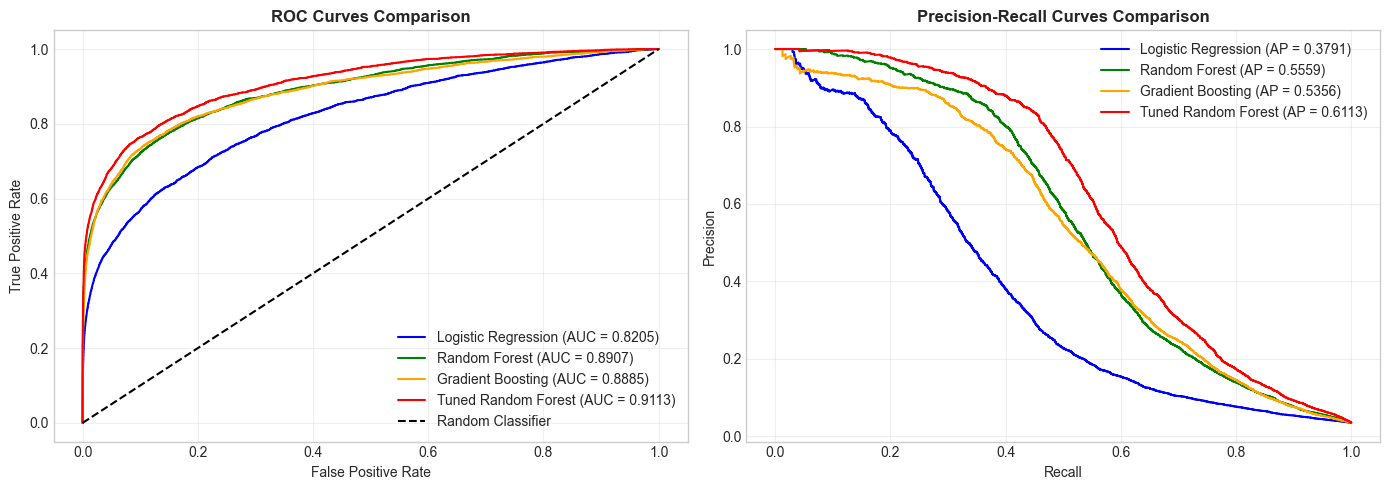

In [23]:
# Visualization: ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
models_data = [
    ('Logistic Regression', lr_pred_proba, 'blue'),
    ('Random Forest', rf_pred_proba, 'green'),
    ('Gradient Boosting', gb_pred_proba, 'orange'),
    ('Tuned Random Forest', best_pred_proba, 'red')
]

for name, pred_proba, color in models_data:
    fpr, tpr, _ = roc_curve(y_val, pred_proba)
    auc = roc_auc_score(y_val, pred_proba)
    axes[0].plot(fpr, tpr, color=color, label=f'{name} (AUC = {auc:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curves
for name, pred_proba, color in models_data:
    precision, recall, _ = precision_recall_curve(y_val, pred_proba)
    avg_precision = average_precision_score(y_val, pred_proba)
    axes[1].plot(recall, precision, color=color, label=f'{name} (AP = {avg_precision:.4f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves Comparison', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

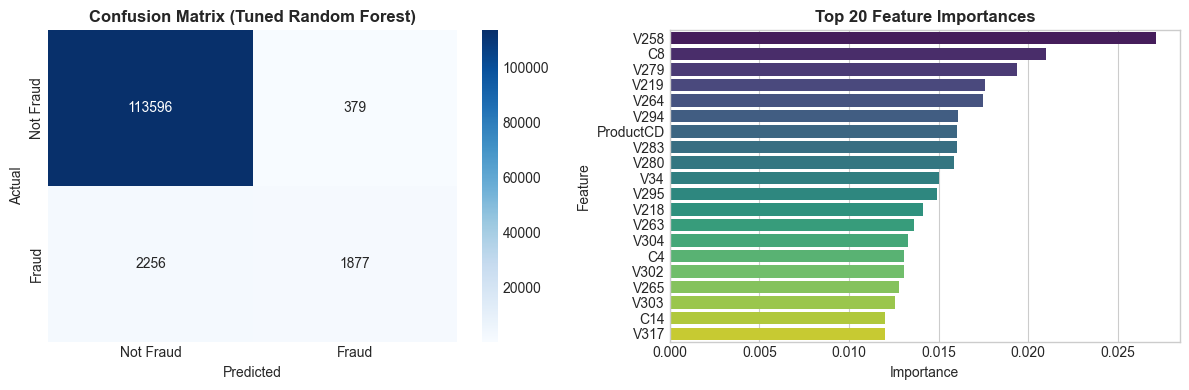


Top 10 Most Important Features:
  feature  importance
     V258    0.027119
       C8    0.021004
     V279    0.019394
     V219    0.017597
     V264    0.017471
     V294    0.016079
ProductCD    0.016057
     V283    0.016030
     V280    0.015886
      V34    0.015012


In [24]:
# Confusion Matrix for best model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
cm = confusion_matrix(y_val, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
axes[0].set_title('Confusion Matrix (Tuned Random Forest)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

sns.barplot(data=feature_importance, x='importance', y='feature', ax=axes[1], palette='viridis')
axes[1].set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 9. Deep Learning Model (Neural Network)

Implementing a simple Neural Network using PyTorch for comparison.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")

# Define the Neural Network model
class FraudDetectionNN(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# Build model
input_dim = X_train_scaled.shape[1]
nn_model = FraudDetectionNN(input_dim).to(device)

# Print model summary
print(f"\nModel Architecture:")
print(nn_model)
total_params = sum(p.numel() for p in nn_model.parameters())
trainable_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

PyTorch version: 2.9.0+cu130
Using device: cuda

Model Architecture:
FraudDetectionNN(
  (network): Sequential(
    (0): Linear(in_features=317, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

Total parameters: 125,569
Trainable parameters: 125,569


In [26]:
# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_resampled.values).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=0.0001)

# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(train_loader), correct / total

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    accuracy = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    auc = roc_auc_score(all_labels, all_preds)
    
    return total_loss / len(val_loader), accuracy, auc

print("Training Neural Network...")

Training Neural Network...


In [27]:
# Training loop with early stopping
epochs = 30
patience = 5
best_val_auc = 0
patience_counter = 0
best_model_state = None

# History for plotting
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_auc': [], 'val_auc': []
}

for epoch in range(epochs):
    # Training
    train_loss, train_acc = train_epoch(nn_model, train_loader, criterion, optimizer)
    
    # Calculate training AUC
    nn_model.eval()
    with torch.no_grad():
        train_preds = nn_model(X_train_tensor).cpu().numpy().flatten()
    train_auc = roc_auc_score(y_train_resampled.values, train_preds)
    
    # Validation
    val_loss, val_acc, val_auc = validate(nn_model, val_loader, criterion)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    
    # Print progress
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - "
          f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - auc: {train_auc:.4f} - "
          f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - val_auc: {val_auc:.4f} - "
          f"lr: {current_lr:.6f}")
    
    # Early stopping
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = nn_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Restore best model
if best_model_state is not None:
    nn_model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_auc: {best_val_auc:.4f}")

Epoch 1/30 - loss: 0.2530 - acc: 0.8962 - auc: 0.9779 - val_loss: 0.1882 - val_acc: 0.9395 - val_auc: 0.8751 - lr: 0.001000
Epoch 2/30 - loss: 0.1981 - acc: 0.9223 - auc: 0.9846 - val_loss: 0.1729 - val_acc: 0.9384 - val_auc: 0.8881 - lr: 0.001000
Epoch 3/30 - loss: 0.1783 - acc: 0.9310 - auc: 0.9862 - val_loss: 0.1375 - val_acc: 0.9537 - val_auc: 0.8961 - lr: 0.001000
Epoch 4/30 - loss: 0.1659 - acc: 0.9366 - auc: 0.9874 - val_loss: 0.1498 - val_acc: 0.9483 - val_auc: 0.9003 - lr: 0.001000
Epoch 5/30 - loss: 0.1567 - acc: 0.9404 - auc: 0.9896 - val_loss: 0.1379 - val_acc: 0.9548 - val_auc: 0.9059 - lr: 0.001000
Epoch 6/30 - loss: 0.1498 - acc: 0.9436 - auc: 0.9906 - val_loss: 0.1243 - val_acc: 0.9611 - val_auc: 0.9075 - lr: 0.001000
Epoch 7/30 - loss: 0.1431 - acc: 0.9467 - auc: 0.9921 - val_loss: 0.1234 - val_acc: 0.9622 - val_auc: 0.9091 - lr: 0.001000
Epoch 8/30 - loss: 0.1386 - acc: 0.9480 - auc: 0.9919 - val_loss: 0.1138 - val_acc: 0.9642 - val_auc: 0.9107 - lr: 0.001000
Epoch 9/

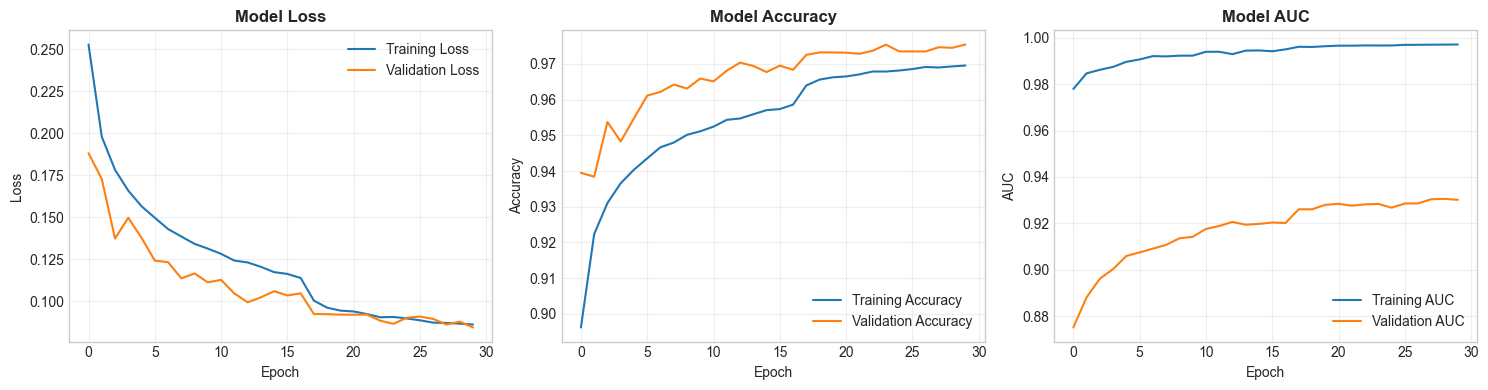

In [28]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Training Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Training Accuracy')
axes[1].plot(history['val_acc'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history['train_auc'], label='Training AUC')
axes[2].plot(history['val_auc'], label='Validation AUC')
axes[2].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Evaluate Neural Network
print("=" * 60)
print("NEURAL NETWORK EVALUATION (PyTorch)")
print("=" * 60)

nn_model.eval()
with torch.no_grad():
    nn_pred_proba = nn_model(X_val_tensor).cpu().numpy().flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)

nn_accuracy = accuracy_score(y_val, nn_pred)
nn_roc_auc = roc_auc_score(y_val, nn_pred_proba)
nn_f1 = f1_score(y_val, nn_pred)
nn_avg_precision = average_precision_score(y_val, nn_pred_proba)

print(f"\nNeural Network Results:")
print(f"  Accuracy: {nn_accuracy:.4f}")
print(f"  ROC-AUC Score: {nn_roc_auc:.4f}")
print(f"  F1 Score: {nn_f1:.4f}")
print(f"  Average Precision: {nn_avg_precision:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_val, nn_pred, target_names=['Not Fraud', 'Fraud']))

nn_metrics = {
    'accuracy': nn_accuracy,
    'roc_auc': nn_roc_auc,
    'f1_score': nn_f1,
    'avg_precision': nn_avg_precision
}

NEURAL NETWORK EVALUATION (PyTorch)

Neural Network Results:
  Accuracy: 0.9755
  ROC-AUC Score: 0.9301
  F1 Score: 0.6335
  Average Precision: 0.6732

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99    113975
       Fraud       0.66      0.61      0.63      4133

    accuracy                           0.98    118108
   macro avg       0.82      0.80      0.81    118108
weighted avg       0.97      0.98      0.97    118108



## 10. Final Model Comparison (ML vs Deep Learning)

FINAL MODEL COMPARISON (ML + Deep Learning)


                     accuracy  roc_auc  f1_score  avg_precision
Logistic Regression    0.8827   0.8205    0.2575         0.3791
Random Forest          0.9743   0.8907    0.5469         0.5559
Gradient Boosting      0.9728   0.8885    0.5358         0.5356
Tuned Random Forest    0.9777   0.9113    0.5876         0.6113
Neural Network         0.9755   0.9301    0.6335         0.6732


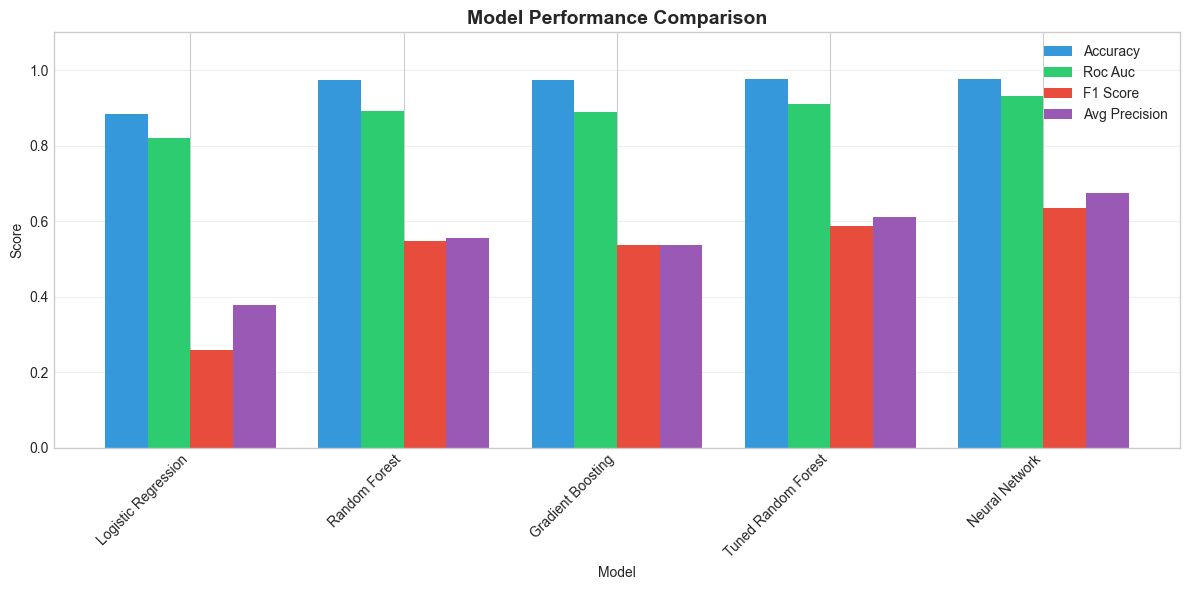


✓ BEST OVERALL MODEL: Neural Network
  ROC-AUC: 0.9301
  F1-Score: 0.6335


In [30]:
# Final comparison including Neural Network
print("=" * 60)
print("FINAL MODEL COMPARISON (ML + Deep Learning)")
print("=" * 60)

final_comparison = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'Tuned Random Forest': best_metrics,
    'Neural Network': nn_metrics
}).T

print("\n")
print(final_comparison.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(final_comparison.index))
width = 0.2

metrics_to_plot = ['accuracy', 'roc_auc', 'f1_score', 'avg_precision']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, final_comparison[metric], width, label=metric.replace('_', ' ').title(), color=colors[i])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(final_comparison.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Best overall model
best_overall = final_comparison['roc_auc'].idxmax()
print(f"\n{'='*60}")
print(f"✓ BEST OVERALL MODEL: {best_overall}")
print(f"  ROC-AUC: {final_comparison.loc[best_overall, 'roc_auc']:.4f}")
print(f"  F1-Score: {final_comparison.loc[best_overall, 'f1_score']:.4f}")
print(f"{'='*60}")

## 11. Generate Predictions on Test Data

In [31]:
# Generate predictions on test data using the best model
print("Generating predictions on test data...")

# Use the Tuned Random Forest for predictions (typically performs well)
test_predictions_proba = best_model.predict_proba(X_test)[:, 1]
test_predictions = (test_predictions_proba > 0.5).astype(int)

# Also generate predictions from Neural Network (PyTorch)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
nn_model.eval()
with torch.no_grad():
    test_predictions_nn_proba = nn_model(X_test_tensor).cpu().numpy().flatten()
test_predictions_nn = (test_predictions_nn_proba > 0.5).astype(int)

print(f"Predictions generated for {len(test_predictions)} transactions")
print(f"\nRandom Forest predictions distribution:")
print(f"  Not Fraud: {(test_predictions == 0).sum():,}")
print(f"  Fraud: {(test_predictions == 1).sum():,}")
print(f"\nNeural Network predictions distribution:")
print(f"  Not Fraud: {(test_predictions_nn == 0).sum():,}")
print(f"  Fraud: {(test_predictions_nn == 1).sum():,}")

Generating predictions on test data...
Predictions generated for 506691 transactions

Random Forest predictions distribution:
  Not Fraud: 497,043
  Fraud: 9,648

Neural Network predictions distribution:
  Not Fraud: 494,218
  Fraud: 12,473


In [32]:
# Create submission file
submission = pd.DataFrame({
    'TransactionID': test_transaction_ids,
    'isFraud': test_predictions_proba  # Probability of fraud
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")
print(f"\nSubmission preview:")
print(submission.head(10))

# Also save the ensemble prediction (average of RF and NN)
ensemble_proba = (test_predictions_proba + test_predictions_nn_proba) / 2
submission_ensemble = pd.DataFrame({
    'TransactionID': test_transaction_ids,
    'isFraud': ensemble_proba
})
submission_ensemble.to_csv('submission_ensemble.csv', index=False)
print("\nEnsemble submission file saved as 'submission_ensemble.csv'")

Submission file saved as 'submission.csv'

Submission preview:
   TransactionID   isFraud
0        3663549  0.031619
1        3663550  0.023146
2        3663551  0.068995
3        3663552  0.010692
4        3663553  0.032583
5        3663554  0.010586
6        3663555  0.185166
7        3663556  0.134802
8        3663557  0.022355
9        3663558  0.031205

Ensemble submission file saved as 'submission_ensemble.csv'


## 12. Summary & Conclusions

In [33]:
# Print final summary
print("=" * 70)
print("FRAUD DETECTION PIPELINE - FINAL SUMMARY")
print("=" * 70)

print("\n📊 DATASET OVERVIEW:")
print(f"   • Training samples: {len(train_df):,}")
print(f"   • Test samples: {len(test_df):,}")
print(f"   • Original features: 393")
print(f"   • Features after preprocessing: {X.shape[1]}")

print("\n⚖️ CLASS IMBALANCE:")
print(f"   • Fraud cases: {(y == 1).sum():,} ({(y == 1).mean()*100:.2f}%)")
print(f"   • Non-fraud cases: {(y == 0).sum():,} ({(y == 0).mean()*100:.2f}%)")
print(f"   • Handled using: SMOTE + Random Undersampling")

print("\n🔧 PREPROCESSING STEPS:")
print("   1. Dropped columns with >80% missing values")
print("   2. Imputed numerical features with median")
print("   3. Imputed categorical features with mode")
print("   4. Label encoded categorical variables")
print("   5. Created time-based features from TransactionDT")
print("   6. Applied log transformation to TransactionAmt")
print("   7. Removed low-variance features")
print("   8. Standardized features for Neural Network")

print("\n🤖 MODELS TRAINED:")
print("   • Logistic Regression (Baseline)")
print("   • Random Forest Classifier")
print("   • Gradient Boosting Classifier")
print("   • Tuned Random Forest (with GridSearchCV)")
print("   • Neural Network (Deep Learning)")

print("\n📈 BEST MODEL PERFORMANCE:")
print(f"   • Model: {best_overall}")
print(f"   • ROC-AUC: {final_comparison.loc[best_overall, 'roc_auc']:.4f}")
print(f"   • F1-Score: {final_comparison.loc[best_overall, 'f1_score']:.4f}")
print(f"   • Accuracy: {final_comparison.loc[best_overall, 'accuracy']:.4f}")

print("\n📁 OUTPUT FILES:")
print("   • submission.csv (Random Forest predictions)")
print("   • submission_ensemble.csv (Ensemble predictions)")

print("\n" + "=" * 70)
print("Pipeline completed successfully!")
print("=" * 70)

FRAUD DETECTION PIPELINE - FINAL SUMMARY

📊 DATASET OVERVIEW:
   • Training samples: 590,540
   • Test samples: 506,691
   • Original features: 393
   • Features after preprocessing: 317

⚖️ CLASS IMBALANCE:
   • Fraud cases: 20,663 (3.50%)
   • Non-fraud cases: 569,877 (96.50%)
   • Handled using: SMOTE + Random Undersampling

🔧 PREPROCESSING STEPS:
   1. Dropped columns with >80% missing values
   2. Imputed numerical features with median
   3. Imputed categorical features with mode
   4. Label encoded categorical variables
   5. Created time-based features from TransactionDT
   6. Applied log transformation to TransactionAmt
   7. Removed low-variance features
   8. Standardized features for Neural Network

🤖 MODELS TRAINED:
   • Logistic Regression (Baseline)
   • Random Forest Classifier
   • Gradient Boosting Classifier
   • Tuned Random Forest (with GridSearchCV)
   • Neural Network (Deep Learning)

📈 BEST MODEL PERFORMANCE:
   • Model: Neural Network
   • ROC-AUC: 0.9301
   • F